In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
from scipy.stats import mannwhitneyu
import datetime
import json
import pickle
from tqdm import tqdm
import warnings
import lightgbm as lgb
import math
import random
import re
warnings.filterwarnings(action='ignore')

from sklearn.metrics import *
from sklearn.model_selection import KFold

def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour)

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)

def split_time(x):
    x = str(x)
    year = x[:4]
    month = x[4:6]
    day = x[6:8]
    hour = x[8:10]
    minute = x[10:12]
    second = x[12:14]
    return year, month, day, hour, minute, second

def make_time_cols(df_):
    years, months, days, hours, minutes, seconds, dates = [], [], [], [], [], [], []

    for i in range(len(df_)):
        x = df_.loc[i,'time']
        year, month, day, hour, minute, second = split_time(x)
        years.append(int(year))
        months.append(int(month))
        days.append(int(day))
        hours.append(int(hour))
        minutes.append(int(minute))
        seconds.append(int(second))
        dates.append(datetime.datetime.strptime(str(x), "%Y%m%d%H%M%S"))

    df_['year'] = years
    df_['month'] = months
    df_['day'] = days
    df_['hour']=hours
    df_['minute'] = minutes
    df_['second']= seconds
    df_['date'] = dates
    return df_


def add_time_cols(df_):
    df_ = make_time_cols(df_)
    df_['weeknum'] = df_['date'].apply(lambda x: x.weekday())
    df_['weekend'] = df_['weeknum'].apply(lambda x: 1 if x >=5 else 0)
    df_['md'] = df_['month'].apply(lambda x: str(x).zfill(2)) + df_['day'].apply(lambda x: str(x).zfill(2))
    return df_

In [2]:
default_path = os.getcwd()
data_path = os.path.join(default_path,'data')

In [3]:
def processing_train_test(data_path, option='train'):
    if option == 'train':
        err_name = 'train_err_data'
        qua_name = 'train_quality_data'
        prob_name = 'train_problem_data'
    elif option == 'test':
        err_name = 'test_err_data'
        qua_name = 'test_quality_data'
    
    df_err = pd.read_csv(data_path+f'/{err_name}.csv')
    df_err['errcode'] = df_err['errcode'].astype('str')
    df_qua = pd.read_csv(data_path+f'/{qua_name}.csv')
    
    for i in range(13):
        df_qua[f'quality_{i}'] = df_qua[f'quality_{i}'].apply(lambda x: re.sub(r"[^0-9]+", '', str(x)) if type(x) == str else x)
        df_qua[f'quality_{i}'] = df_qua[f'quality_{i}'].astype(float)
    
    df_err['errcode'] = df_err['errcode'].astype(str)
    df_err['fwver'] = df_err['fwver'].astype(str)
    df_err['model_nm'] = df_err['model_nm'].astype(str)
    
    df_qua['fwver'] = df_qua['fwver'].astype(str)
    
    
    files = [f'{err_name}_c', f'{qua_name}_c']
    temp_dfs = [df_err, df_qua]
    
    if option == 'train':
        files.append(f'{prob_name}_c')
        
        df_prob = pd.read_csv(data_path+f'/{prob_name}.csv')
        temp_dfs.append(df_prob)
    
    for i in tqdm(range(len(files))):
        file = files[i]
        if not os.path.isfile(f'{data_path}/{file}.csv'):
            temp_dfs[i] = add_time_cols(temp_dfs[i])
            temp_dfs[i].to_csv(f'{data_path}/{file}.csv', index=False)
            temp_dfs[i] = pd.read_csv(f'{data_path}/{file}.csv', parse_dates=['date'])
        else:
            pass

In [4]:
processing_train_test(data_path, 'train')
processing_train_test(data_path, 'test')

100%|██████████| 2/2 [00:00<00:00, 6457.74it/s]


In [5]:
def make_change_dict(err_df, data_path, option = 'train'):
    change_dict = {}
    change_dict['id'] = []
    change_dict['upgrade'] = []
    change_dict['downgrade'] = []
    change_dict['change_model'] = []
    change_dict['change_version'] = []
    change_dict['change_all'] = []
    all_ids = np.unique(err_df['user_id'])
    
    if not os.path.isfile(f"{data_path}/{option}_upgrade_dict.json"):
        for id_ in tqdm(all_ids):
            temp_df = err_df[err_df['user_id']==id_].sort_values('date').reset_index(drop=True)

            unique_model = np.unique(temp_df['model_nm'])
            unique_version = np.unique(temp_df['fwver'])

            if len(unique_model) != 1 or len(unique_version)!=1:

                past_version = temp_df.loc[0,'fwver']
                past_model = temp_df.loc[0,'model_nm']
                upgrade = 0
                downgrade = 0
                change_model = 0
                change_version = 0
                change_all = 0

                for i in range(1,len(temp_df)):
                    cur_version = temp_df.loc[i,'fwver']
                    cur_model = temp_df.loc[i,'model_nm']
                    sw = 0
                    if past_model != cur_model:
                        change_model +=1
                        change_all +=1
                        sw = 1
                        
                    if past_version != cur_version:
                        change_version +=1
                        
                        past_version_f = past_version.split('.')
                        past_version_f = float(past_version_f[0] + '.' + ''.join(past_version_f[1:]))

                        cur_version_f = cur_version.split('.')
                        cur_version_f = float(cur_version_f[0] + '.' + ''.join(cur_version_f[1:]))
                        if past_model != cur_model and past_version_f > cur_version_f:
                            downgrade +=1
                        elif past_model != cur_model and past_version_f < cur_version_f:
                            upgrade +=1
                        if sw == 0:
                            change_all +=1  
                        
                    past_version = cur_version
                    past_model = cur_model

                change_dict['id'].append(id_)
                change_dict['upgrade'].append(upgrade)
                change_dict['downgrade'].append(downgrade)
                change_dict['change_model'].append(change_model)
                change_dict['change_version'].append(change_version)
                change_dict['change_all'].append(change_all)

        change_dict['id'] =list(map(int, change_dict['id']))
        with open(f"{data_path}/{option}_upgrade_dict.json", "w") as f:
            json.dump(change_dict, f)
    else:
        pass

In [6]:
train_err = pd.read_csv(data_path+'/train_err_data_c.csv')
test_err = pd.read_csv(data_path+'/test_err_data_c.csv')

In [7]:
if not os.path.isfile(f"{data_path}/train_upgrade_dict.json"):
    make_change_dict(train_err, data_path, option = 'train')
if not os.path.isfile(f"{data_path}/test_upgrade_dict.json"):
    make_change_dict(test_err, data_path, option = 'test')

In [8]:
with open(f"{data_path}/train_upgrade_dict.json", "r") as f:
    train_change_dict = json.load(f)
with open(f"{data_path}/test_upgrade_dict.json", "r") as f:
    test_change_dict = json.load(f)

In [9]:
def extract_change_df(change_dict):

    change_df = pd.DataFrame({'user_id':change_dict['id'], 'upgrade':change_dict['upgrade'],
                         'downgrade':change_dict['downgrade'], 'change_model':change_dict['change_model'],
                         'change_version':change_dict['change_version'],
                         'change_all':change_dict['change_all']})
    return change_df

In [10]:
train_change_df = extract_change_df(train_change_dict)
test_change_df = extract_change_df(test_change_dict)

In [11]:
train_qua = pd.read_csv(data_path+'/train_quality_data_c.csv')
test_qua = pd.read_csv(data_path+'/test_quality_data_c.csv')

## 모델링

In [12]:
def processing_qua(qua_df):
    quality_cols = [f'quality_{i}' for i in range(13)]
    temp_size_qua = qua_df.groupby(['user_id','date']).sum().reset_index()
    temp_size_qua = temp_size_qua.groupby(['user_id']).size().to_frame('quality_num').reset_index()
    temp_size_qua['quality_num'] = temp_size_qua['quality_num'].apply(lambda x: 1 if x != 0 else 0)
    
    temp_mean_qua = qua_df.copy()
    temp_mean_qua = temp_mean_qua.fillna(0)
    temp_mean_qua = temp_mean_qua.groupby(['user_id']).mean().reset_index()[['user_id']+quality_cols]
    f_qua_df = pd.merge(temp_size_qua, temp_mean_qua, on='user_id', how='left')
    return f_qua_df

def make_pivot_table(err_df, col, appear_option = False, test_err_df=None, test_option=False):
    err_pivot = err_df.groupby(['user_id',col]).size().to_frame('size').reset_index()
    err_pivot= pd.pivot_table(err_pivot, index='user_id', columns=[col], values='size').add_prefix(f'col_{col}_')
    err_pivot.index.name = None
    err_pivot.columns.name = None
    err_pivot = err_pivot.fillna(0)
    err_pivot['user_id'] = err_pivot.index.tolist()
    err_pivot = err_pivot.reset_index(drop=True)
    if test_option == True:
        test_unique_values = np.unique(test_err_df[col])
        need_cols = np.setdiff1d(test_unique_values, np.unique(err_df[col]))
        for t_col in need_cols:
            err_pivot[f'col_{col}_{t_col}'] = 0
            
    if appear_option == True:
        for t_col in err_pivot:
            err_pivot[t_col] = err_pivot[t_col].apply(lambda x: 1 if x != 0 else 0)
        
    return err_pivot

In [13]:
train_ids = np.unique(train_err['user_id'])

In [57]:
# 모델 추출
def make_model_df(train_err, col):
    temp_df = train_err.groupby([col,'user_id']).sum().reset_index()
    temp_df = temp_df.groupby([col,'user_id']).size().to_frame('size').reset_index()
    model_pivot = pd.pivot_table(temp_df, index='user_id', columns=col, values='size').fillna(0)
    model_pivot.index.name = None
    model_pivot.columns.name = None
    model_pivot['user_id'] = model_pivot.index.tolist()
    model_pivot = model_pivot.reset_index(drop=True)
    return model_pivot
#model_pivot = make_model_df(train_err, 'model_nm')

In [58]:
train_errtype_pivot = make_pivot_table(train_err, 'errtype')
train_errcode_pivot = make_pivot_table(train_err, 'errcode')
train_md_pivot = make_pivot_table(train_err, 'md', False, test_err, True)
train_all_error = train_err.groupby(['user_id']).size().to_frame('all_error').reset_index()
train_model_pivot = make_pivot_table(train_err, 'model_nm', True)
#train_fwver_pivot = make_pivot_table(train_err, 'fwver', True, test_err, True)

In [59]:
train_ids = np.unique(train_err['user_id'])
train_data = pd.DataFrame({'user_id': train_ids})
train_data = pd.merge(train_data, train_errtype_pivot, on='user_id', how='left')
#train_data = pd.merge(train_data, train_errcode_pivot, on='user_id', how='left')
train_data = pd.merge(train_data, train_all_error, on='user_id', how='left')
train_data = pd.merge(train_data, train_change_df, on='user_id', how='left')
train_data = pd.merge(train_data, train_md_pivot, on='user_id', how='left')
#train_data = pd.merge(train_data, train_fwver_pivot, on='user_id', how='left')

train_data = pd.merge(train_data, train_model_pivot, on='user_id', how='left')
#train_data = pd.merge(train_data, model_pivot, on='user_id', how='left')

In [60]:
change_df_cols = ['upgrade','downgrade','change_model','change_version','change_all']
for col in change_df_cols:
    train_data[col] = train_data[col].fillna(0)

In [61]:
# qua 합치기
quality_cols = [f'quality_{i}' for i in range(13)]
train_qua_pivot = processing_qua(train_qua)
train_data = pd.merge(train_data, train_qua_pivot, on='user_id', how='left')
for col in quality_cols:
    train_data[col] = train_data[col].fillna(0)

In [62]:
train_prob = pd.read_csv(data_path+'/train_problem_data_c.csv', parse_dates=['date'])
prob_user_ids = np.unique(train_prob['user_id'])

In [63]:
train_data['y'] = train_data['user_id'].apply(lambda x: 1 if x in prob_user_ids else 0)

In [64]:
train_x = train_data.loc[:,~train_data.columns.isin(['y','user_id'])]
x_columns = train_x.columns
train_y = train_data[['y']]

In [65]:
train_data

,user_id,col_errtype_1,col_errtype_2,col_errtype_3,col_errtype_4,col_errtype_5,col_errtype_6,col_errtype_7,col_errtype_8,col_errtype_9,...,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,y
0,10000,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.500000,0.000000,0.00,0.0,0.000,6.000,0.000000,0.0,0
1,10001,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,...,0.0,0.000000,0.000000,0.00,0.0,0.000,0.000,0.000000,0.0,1
2,10002,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,...,0.0,0.343750,0.458333,5.75,0.0,0.125,3.875,-0.020833,0.0,0
3,10003,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,...,0.0,0.000000,0.000000,0.00,0.0,0.000,0.000,0.000000,0.0,0
4,10004,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,...,0.0,0.250000,3.541667,43.50,0.0,0.000,2.000,-0.083333,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,24995,0.0,0.0,0.0,0.0,2.0,5.0,5.0,0.0,0.0,...,0.0,0.625000,-0.416667,0.00,0.0,0.000,2.500,-0.416667,0.0,0
14996,24996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.00,0.0,0.000,0.000,0.000000,0.0,0
14997,24997,0.0,0.0,0.0,1.0,8.0,1.0,1.0,0.0,0.0,...,0.0,0.958333,-0.166667,0.00,0.0,0.000,9.500,-0.166667,0.0,1
14998,24998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.00,0.0,0.000,0.000,0.000000,0.0,1


In [66]:
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------
models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5
# 파라미터 설정
params =      {
                'boosting_type' : 'gbdt',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'seed': 1015,
                'n_estimators':3000
                }
#-------------------------------------------------------------------------------------
# 5 Kfold cross validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in k_fold.split(train_x):

    # split train, validation set
    X = train_x.loc[train_idx,:]
    y = train_y.loc[train_idx,:]
    valid_x = train_x.loc[val_idx,:]
    valid_y = train_y.loc[val_idx,:]

    d_train= lgb.Dataset(X, y)
    d_val  = lgb.Dataset(valid_x, valid_y)
    
    #run traning
    model = lgb.train(
                        params,
                        train_set       = d_train,
                        num_boost_round = 1000,
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 30, 
                        early_stopping_rounds = 10
                       )
    
    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')

[LightGBM] [Info] Number of positive: 3633, number of negative: 8367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14663
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.302750 -> initscore=-0.834237
[LightGBM] [Info] Start training from score -0.834237
Training until validation scores don't improve for 10 rounds
[30]	valid_0's auc: 0.816829	valid_0's pr_auc: 0.816313
Early stopping, best iteration is:
[37]	valid_0's auc: 0.819074	valid_0's pr_auc: 0.817878
[LightGBM] [Info] Number of positive: 4828, number of negative: 7172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14822
[LightGBM] [Info] Number of

In [67]:
#0.8139364493841612, 0.8137698954081596
print(np.mean(auc_scores))

0.8108726280819774


In [68]:
test_ids = np.unique(test_err['user_id'])

In [71]:
test_errtype_pivot = make_pivot_table(test_err, 'errtype')
test_errcode_pivot = make_pivot_table(test_err, 'errcode')
test_model_pivot = make_pivot_table(test_err, 'model_nm', True)
test_fwver_pivot = make_pivot_table(test_err, 'fwver', True, train_err, True)

test_md_pivot = make_pivot_table(test_err, 'md')
test_all_error = test_err.groupby(['user_id']).size().to_frame('all_error').reset_index()

In [72]:
test_data = pd.DataFrame({'user_id': test_ids})
test_data = pd.merge(test_data, test_errtype_pivot, on='user_id', how='left')
#test_data = pd.merge(test_data, test_errcode_pivot, on='user_id', how='left')
test_data = pd.merge(test_data, test_all_error, on='user_id', how='left')
test_data = pd.merge(test_data, test_change_df, on='user_id', how='left')
test_data = pd.merge(test_data, test_md_pivot, on='user_id', how='left')

test_data = pd.merge(test_data, test_model_pivot, on='user_id', how='left')
#test_data = pd.merge(test_data, model_df, on='user_id', how='left')

In [73]:

change_df_cols = ['upgrade','downgrade','change_model','change_version','change_all']
for col in change_df_cols:
    test_data[col] = test_data[col].fillna(0)


In [74]:
# qua 합치기
quality_cols = [f'quality_{i}' for i in range(13)]
test_qua_pivot = processing_qua(test_qua)
test_data = pd.merge(test_data, test_qua_pivot, on='user_id', how='left')
for col in quality_cols:
    test_data[col] = test_data[col].fillna(0)


In [75]:
test_x = test_data.loc[:,~test_data.columns.isin(['y','user_id'])]
test_x = test_x.loc[:,x_columns]

In [76]:
pred_y_list = []
for model in models:
    pred_y = model.predict(test_x)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)

<AxesSubplot:ylabel='Density'>

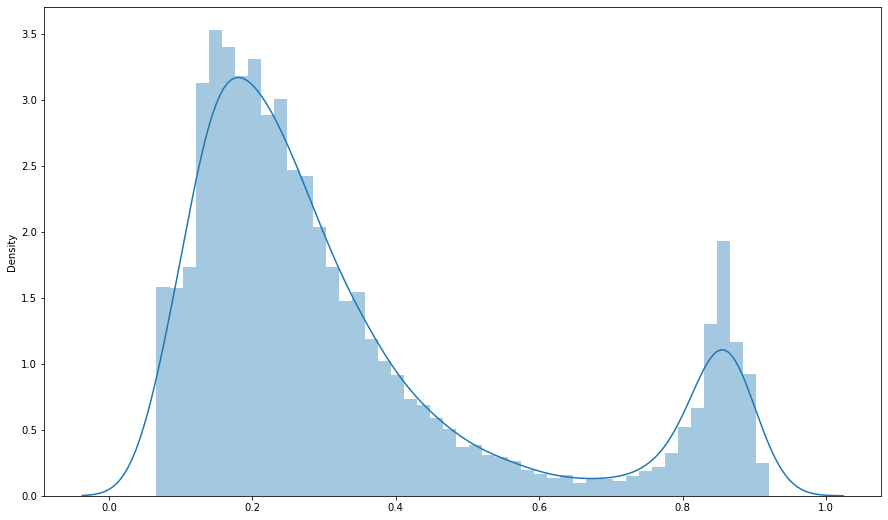

In [80]:
plt.figure(figsize=(15,9))
sns.distplot(pred_ensemble)

<AxesSubplot:ylabel='Density'>

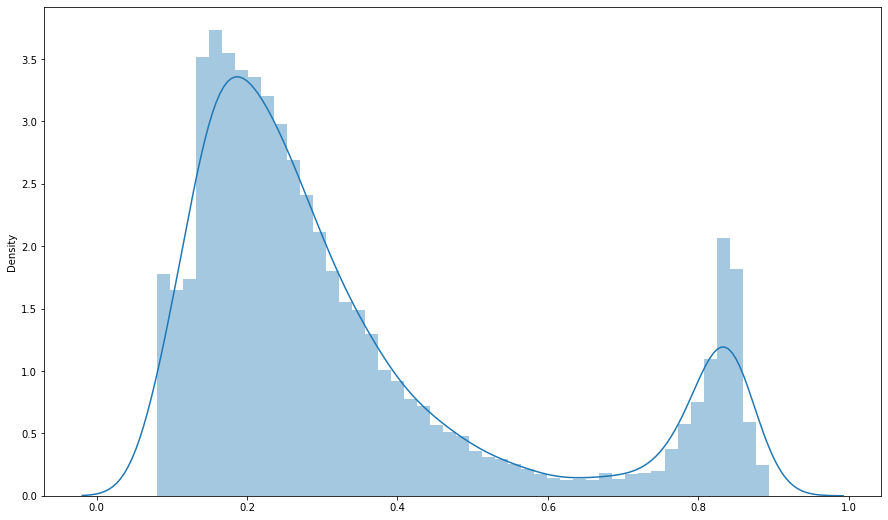

In [504]:
plt.figure(figsize=(15,9))
sns.distplot(pred_ensemble)

<AxesSubplot:ylabel='Density'>

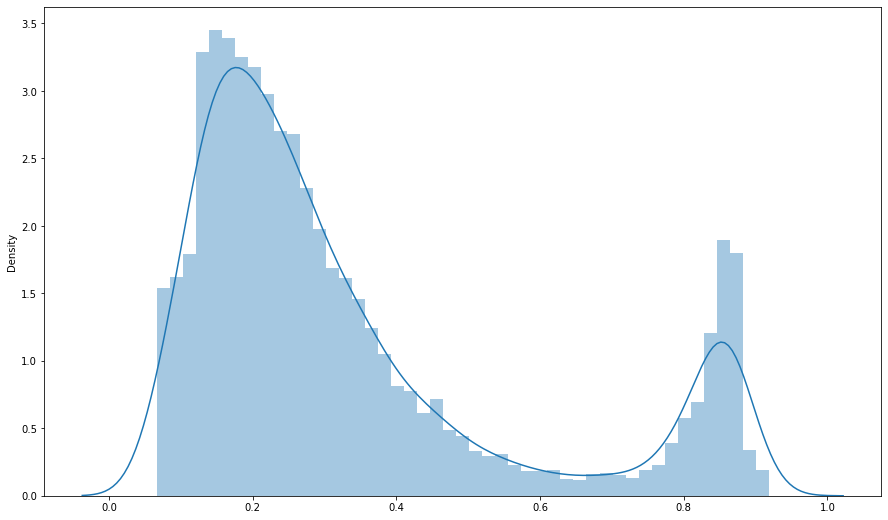

In [478]:
plt.figure(figsize=(15,9))
sns.distplot(pred_ensemble)

<AxesSubplot:ylabel='Density'>

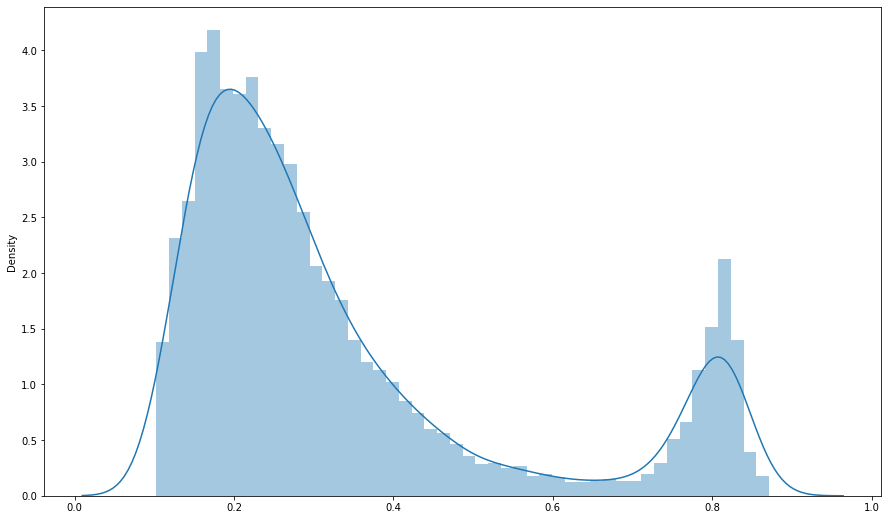

In [383]:
plt.figure(figsize=(15,9))
sns.distplot(pred_ensemble)

<AxesSubplot:ylabel='Density'>

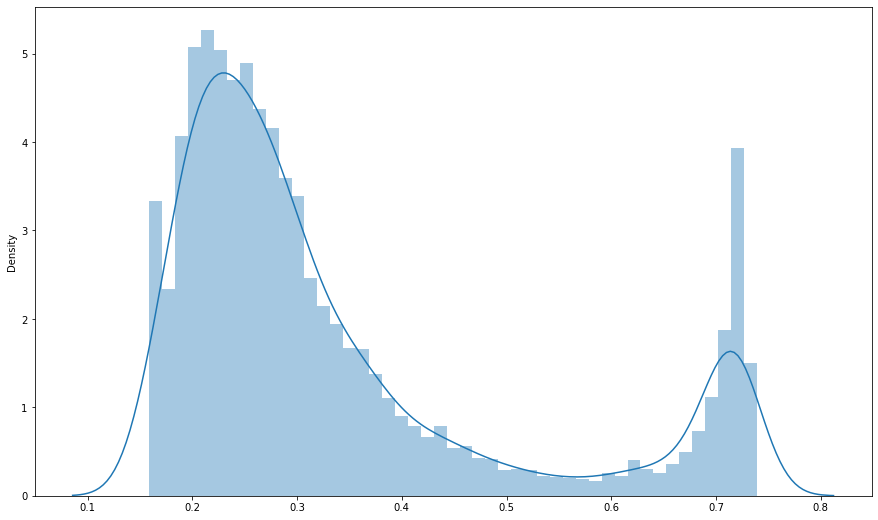

In [192]:
plt.figure(figsize=(15,9))
sns.distplot(pred_ensemble)

In [81]:
sample_sub = pd.read_csv(data_path+'/sample_submission.csv')
sample_sub = sample_sub.drop('problem', axis=1)

In [82]:
pred_y = pd.DataFrame({'user_id':test_data['user_id'], 'problem':pred_ensemble[:,0]})

In [83]:
sample_sub = pd.merge(sample_sub, pred_y, on='user_id', how='left')
sample_sub['problem'] = sample_sub['problem'].fillna(0)

In [84]:
sample_sub.to_csv("result_new2.csv", index = False)

In [119]:
sample_sub

,user_id,problem
0,30000,0.577556
1,30001,0.260899
2,30002,0.315576
3,30003,0.535576
4,30004,0.454501
...,...,...
14994,44994,0.329001
14995,44995,0.315880
14996,44996,0.383020
14997,44997,0.616116


<AxesSubplot:xlabel='problem', ylabel='Density'>

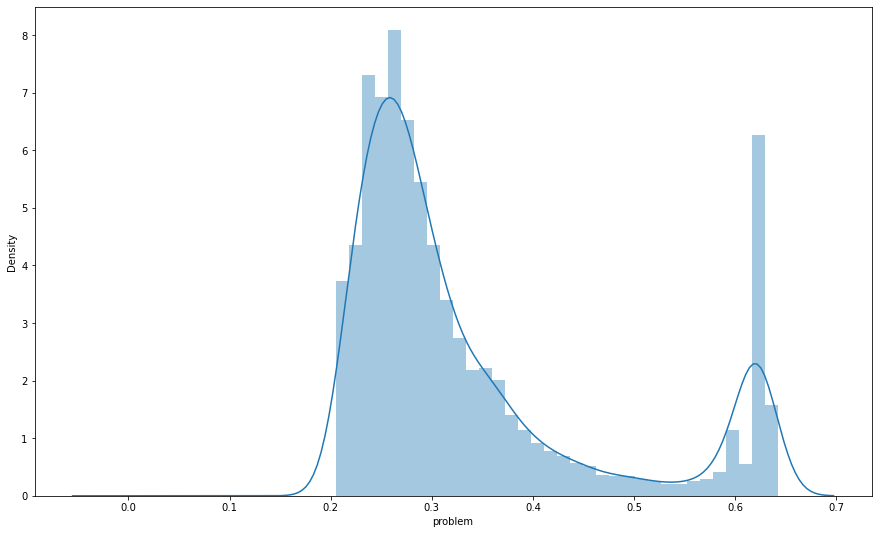

In [145]:
plt.figure(figsize=(15,9))
sns.distplot(sample_sub['problem'])

<AxesSubplot:ylabel='Density'>

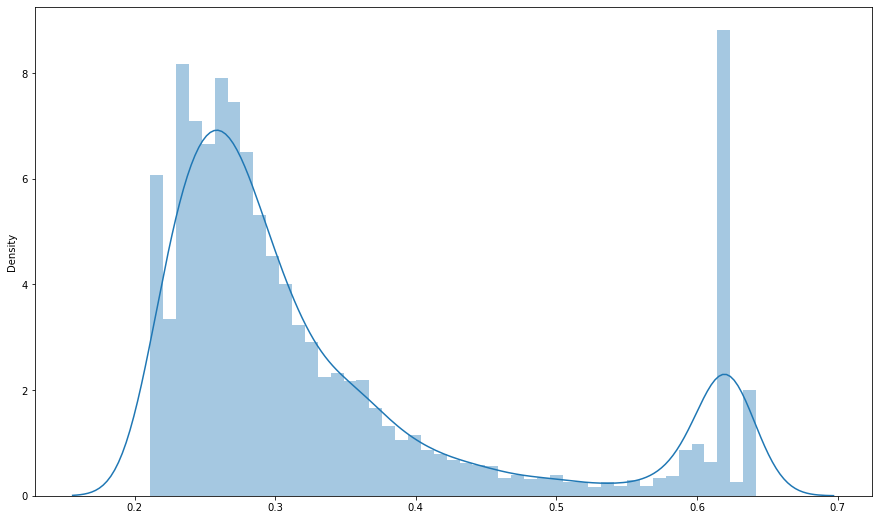

In [140]:
plt.figure(figsize=(15,9))
sns.distplot(pred_ensemble)


In [12]:
temp_err = pd.read_csv(data_path+'/train_err_data.csv')

In [13]:
train_user_id_max = 24999
train_user_id_min = 10000
train_user_number = 15000

In [14]:

id_error = temp_err[['user_id','errtype']].values
error = np.zeros((train_user_number,42))

for person_idx, err in tqdm(id_error):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - train_user_id_min,err - 1] += 1
error.shape

100%|██████████| 16554663/16554663 [00:36<00:00, 455401.94it/s]


(15000, 42)

In [32]:
temp_prob = pd.read_csv(data_path+'/train_problem_data.csv')
problem = np.zeros(15000)
# error와 동일한 방법으로 person_idx - 10000 위치에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0
problem[temp_prob.user_id.unique()-10000] = 1 
problem.shape

(15000,)

In [33]:
# 변수 이름 변경
# error  -> train_x
# problem-> train_y

train_x = error
train_y = problem
del error, problem
print(train_x.shape)
print(train_y.shape)

(15000, 42)
(15000,)
